## TL;DR
It is recommended that we proceed with the proposed change of initiating the background check sooner in the onboarding process.<br>
Below are some platform improvements we expect to see:
* Improved Success rates
* Lower cost of aquisition
* Increase of shopper supply
* Improved shopper onboarding experience by reducing wait time

## Hypothesis
By initiating the required background check process sooner in the shopper onboarding flow we believe that a shopper will be more likely to finish the process and complete their first job.

## Experiment Design
We have performed a randomized A/B experiment on new shoppers to determine the effect on conversion and timeliness of the conversions by an earlier initiation of the required background check

#### Experiment Design (cont.)
For the experiment, we have decided on two primary metrics (Listed in order of importance):
1. Success Rate (1 if shopper completed their first shop)
2. Days to complete (Nr of days between *application_date* and *first_batch_completed_date*)

The goal of our experiment will be to determine if the treatment group shows statistical significance for each metric. We expect an increase in the **Success Rate** and a decrease in **Days to Complete**.

Given our large sample size we have determined an appropriate alpha level of *0.01* (0.005 since we are interested in 1 tail). By doing this, we drastically reduce the odds of a false positive test giving us more confidence in the results.

## Summary of Findings

#### Summary

Both of our metrics (*Success Rate* and *Days to complete*) proved to be statistically significant.<br>
The following table is a summary of the net results

Metric  | Net Effect | Net Effect Confidence Interval (0.99) 
------------- | ------------- | ------------- 
Success Rate | 0.7329 | (0.622,  0.852) 
Days to Complete | -0.307 | (-0.324,  -0.289) 

Given our current aquisition costs and our expected success rate improvement, we can derive the following expected aquisition cost savings:

Background Check Cost  | Cost Savings per Successful onboard
------------- | -------------
30 |25.78  
50 | 42.96
100 |  85.91

Under our current assumptions, there is no additional cost of requiring the background check earlier in our process therfore by making this change we would realize the full extent of the above savings.<br> 
Additionally, by improving our success rate we are now helping the platform as a whole by the additional shoppers

#### Concerns
One potential concern in the data is the fact that all shoppers in the treatment group initiated the background check.
It is difficult to tell if this is a bug or by design. To mitigate this potential risk, another test was performed on the success rate when the samples were filtered to shoppers who did initiate the background check. The results were still significant.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower

In [3]:
def get_histograms(df, feature):
    fig, ax = plt.subplots(figsize=(12,6))  
    control = df[df.group == 'control'][feature]
    treatment = df[df.group == 'treatment'][feature]
    ax.hist(control, bins=50, color='g', density=True, histtype='step'
                , label=f'Control: {np.round(np.mean(control), 3)}')
    ax.hist(treatment, bins=50, color='r', density=True, histtype='step'
                , label=f'Treatment: {np.round(np.mean(treatment), 3)}')
    plt.legend()
    plt.title(f"{feature}")
    
    
def ttest(df, feature, alpha):
    '''
    1 sided, 2 sample t-test
    
    '''
    control = df[df['group'] == 'control'][feature].tolist()
    treatment = df[df['group'] == 'treatment'][feature].tolist()
    ttest,pval = ttest_ind(control, treatment, nan_policy='omit')
    significance = int(pval < alpha)
    control_mean = np.mean([i for i in control if not math.isnan(i)])
    treatment_mean = np.mean([i for i in treatment if not math.isnan(i)])
    net_effect = (treatment_mean - control_mean)/control_mean
    print(f"""
    {feature}
    Control mean: {control_mean} 
    Treatment mean: {treatment_mean}
    test statistic: {ttest}
    p-value: {pval}
    Significance: {significance}
    Net Effect: {np.round(net_effect, 4)}
    """)
    
    return ttest, pval, significance, net_effect    

In [4]:
df = pd.read_csv("/Users/williamcasey/Desktop/icart.csv")
alpha = 0.01/2

In [5]:
df.isna().sum()

applicant_id    0
channel         0
group           0
city            0
event           0
event_date      0
dtype: int64

In [6]:
df.head(1)

,applicant_id,channel,group,city,event,event_date
0,10001,web-search-engine,control,Asgard,application_date,10/1/18


#### Transform Dataset

In [7]:
df_pivot = df.pivot(index='applicant_id', columns='event', values='event_date')
df_pivot['first_batch_completed_date'] = df_pivot.first_batch_completed_date.astype('str')
df_pivot['background_check_initiated_date'] = df_pivot.background_check_initiated_date.astype('str')

df_pivot['success'] = df_pivot.first_batch_completed_date.apply(lambda x: 1 if x != 'nan' else 0)
df_pivot['is_background_check_initiated_date'] = (df_pivot
                                                 .background_check_initiated_date
                                                 .apply(lambda x: 1 if x != 'nan' else 0)
                                                 )

df_pivot = df_pivot.merge(df[['applicant_id', 'group', 'city']].drop_duplicates(),
                          right_on='applicant_id',
                          left_index=True, 

                         )


df_pivot[df_pivot['success'] == 1]
df_pivot['first_batch_completed_date'] = pd.to_datetime(df_pivot['first_batch_completed_date'])
df_pivot['application_date'] = pd.to_datetime(df_pivot['application_date'])
df_pivot['days_to_complete'] = (df_pivot.first_batch_completed_date - df_pivot.application_date).dt.days



#Get 'n' (to be used later)
control_n, treatment_n = (df_pivot.groupby('group').group.count().control, 
                         df_pivot.groupby('group').group.count().treatment)

In [10]:
df_pivot.head()

,application_date,background_check_completed_date,background_check_initiated_date,card_activation_date,card_mailed_date,first_batch_completed_date,orientation_completed_date,success,is_background_check_initiated_date,applicant_id,group,city,days_to_complete
0,2018-10-01,NaN,nan,NaN,10/1/18,NaT,10/3/18,0,0,10001,control,Asgard,NaN
1,2018-10-01,10/17/18,10/12/18,10/12/18,10/1/18,2018-10-20,NaN,1,1,10002,control,Midgard,19.0
2,2018-10-01,10/8/18,10/1/18,10/4/18,10/2/18,NaT,10/5/18,0,1,10003,treatment,Midgard,NaN
3,2018-10-01,10/5/18,10/1/18,10/4/18,10/1/18,2018-10-06,NaN,1,1,10004,treatment,Asgard,5.0
4,2018-10-01,10/7/18,10/1/18,10/8/18,10/1/18,2018-10-08,10/1/18,1,1,10005,treatment,Midgard,7.0


#### Understanding our dataset
Other than just understanding the data, one goal of this exploration exercise is to ensure that the A/B test is in fact random. 

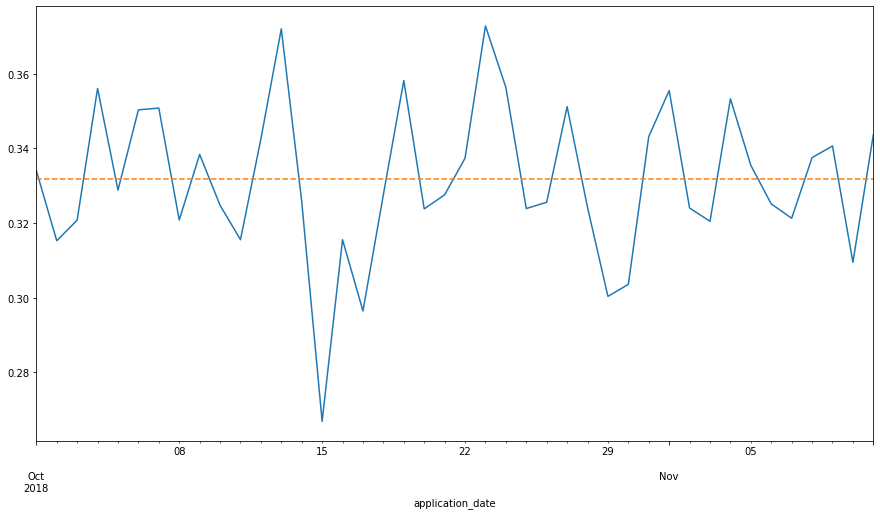

In [481]:
df_ab_over_time = (df_pivot.groupby(["application_date", "group"]).group.count()
            .to_frame()
            .rename(columns={'group': 'cnt'})
            .reset_index()
            .pivot(index='application_date', columns='group', values='cnt')
            
 
)
(df_ab_over_time.treatment/(df_ab_over_time.control + df_ab_over_time.treatment)).plot(figsize=(15, 8))
df_ab_over_time['overall_success_rate'] = [treatment_n/(control_n + treatment_n) 
                                           for i in range(len(df_ab_over_time))]
df_ab_over_time['overall_success_rate'].plot(ls='--')

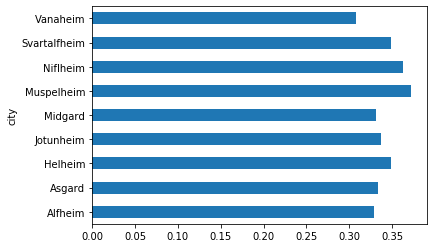

In [482]:
df_ab_by_city = (df_pivot.groupby(["city", "group"]).group.count()
            .to_frame()
            .rename(columns={'group': 'cnt'})
            .reset_index()
            .pivot(index='city', columns='group', values='cnt')
            
 
)

(df_ab_by_city['treatment']/(df_ab_by_city['control'] + df_ab_by_city['treatment'])).plot(kind='barh')


#### Power test to determine required effect given test parameters
We run the power test to better understand our risk of a False Negative. This allows us to speak to our stakeholders with more confidence when providing the results

In [483]:

power = 0.995 # 1- beta aka 1 - probability(Type II error)
result = TTestIndPower().solve_power(effect_size=None, 
                                     power=power, 
                                     nobs1=control_n, 
                                     ratio=treatment_n/control_n, 
                                     alpha=alpha, 
                                     alternative='larger')
print(f"In order to achieve a power of {power}, we must see an effect of {np.round(result, 4)}")


In order to achieve a power of 0.995, we must see an effect of 0.0743



    success
    Control mean: 0.1981242672919109 
    Treatment mean: 0.3433375017368348
    test statistic: -23.67355764619813
    p-value: 2.400319313853911e-122
    Significance: 1
    Net Effect: 0.7329
    


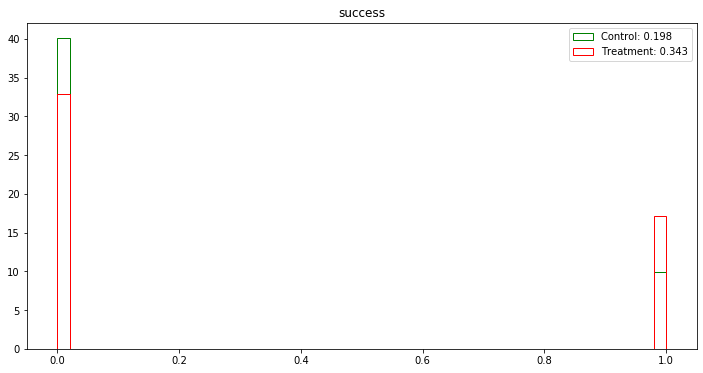

In [639]:
success_ttest, success_pval, success_significance, success_net_effect = ttest(df=df_pivot,   
                                                                            feature='success', 
                                                                              alpha=alpha)
get_histograms(df=df_pivot, feature='success')


    days_to_complete
    Control mean: 10.002088409328229 
    Treatment mean: 6.931606636989073
    test statistic: 42.39108902473685
    p-value: 0.0
    Significance: 1
    Net Effect: -0.307
    


/Users/williamcasey/.envs/frs/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/williamcasey/.envs/frs/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


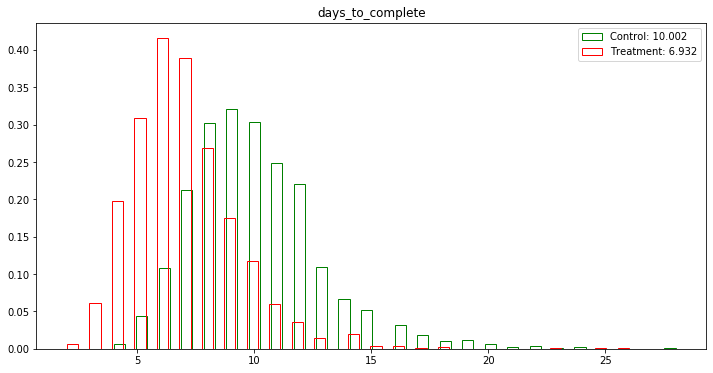

In [640]:
days_to_complete_ttest, days_to_complete_pval, days_to_complete_significance, days_to_complete_net_effect  = ttest(df=df_pivot, feature='days_to_complete', alpha=alpha)
get_histograms(df=df_pivot, feature='days_to_complete')

#### Filtering to shoppers who initiated background check


    success
    Control mean: 0.2651347360649686 
    Treatment mean: 0.3433375017368348
    test statistic: -11.301290653775334
    p-value: 1.6251734394028988e-29
    Significance: 1
    Net Effect: 0.295
    


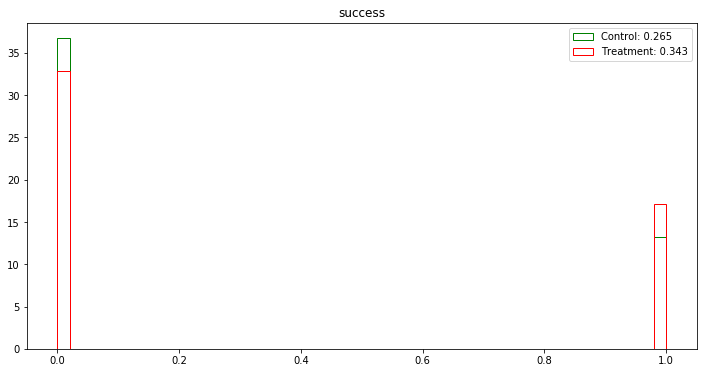

In [653]:
data = df_pivot[df_pivot['is_background_check_initiated_date'] == 1]
success_ttest, success_pval, success_significance, success_net_effect = ttest(df=data,   
                                                                            feature='success', 
                                                                              alpha=alpha)
get_histograms(df=data, feature='success')

### Modeling the uncertanity of our net effect
Point estimates such as "*the effect will be 0.7329*" can be dangerous.<br> It is more prudent for the data scientist to provide expected ranges of the point estimate.<br>
My preferred methodology for this is bootstrapping.

In [590]:
def bootstrap(df, frac, feature):
    df = df[['group', feature]].sample(frac=frac)
    mean_dict = df.groupby('group').agg({feature: np.mean}).to_dict()[feature]
    return (mean_dict['treatment'] - mean_dict['control'])/mean_dict['control']

def get_bootstrap_confidence_int(data, alpha):
    ci_alpha = (alpha*100)/2
    return np.percentile(data, ci_alpha), np.percentile(data, 100 - ci_alpha)

In [559]:
success_bootstrap = [bootstrap(df=df_pivot, frac=0.25, 
                        feature='success') for i in range(10000)]
days_to_complete_bootstrap = [bootstrap(df=df_pivot, frac=0.25, 
                             feature='days_to_complete') for i in range(10000)]


We are 99% confident that the Success Rate 
net effect is between 0.622 and 0.852


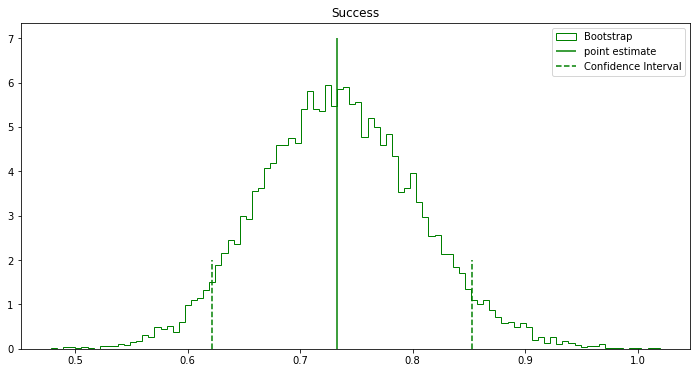

In [609]:
ci_lower, ci_upper = get_bootstrap_confidence_int(success_bootstrap, alpha=0.1)

fig, ax = plt.subplots(figsize=(12,6))  

ax.hist(success_bootstrap, bins=100, color='g', density=True, histtype='step'
            , label=f'Bootstrap')
plt.vlines(x=success_net_effect, ymin=0, ymax=7, color='g', label='point estimate')
plt.vlines(x=ci_lower, ymin=0, ymax=2, color='g', ls='--', label='Confidence Interval')
plt.vlines(x=ci_upper, ymin=0, ymax=2, color='g', ls='--')

plt.legend()
plt.title("Success")
print(f"We are 99% confident that the Success Rate \nnet effect is between {np.round(ci_lower, 3)} and {np.round(ci_upper, 3)}")



We are 99% confident that the Days to complete 
net effect is between -0.324 and -0.289


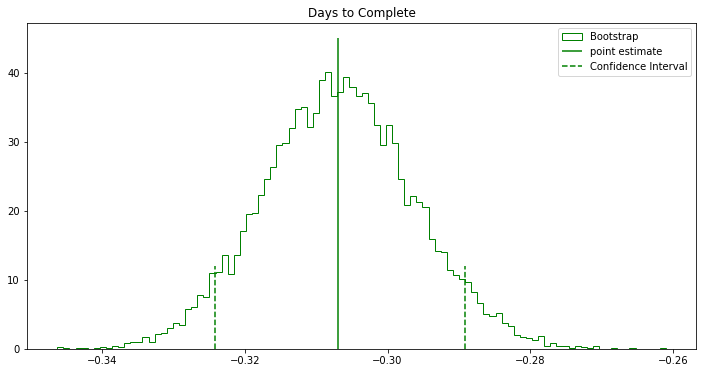

In [608]:
ci_lower, ci_upper = get_bootstrap_confidence_int(days_to_complete_bootstrap, alpha=0.1)

fig, ax = plt.subplots(figsize=(12,6))  
ax.hist(days_to_complete_bootstrap, bins=100, color='g', density=True, histtype='step'
            , label=f'Bootstrap')
plt.vlines(x=days_to_complete_net_effect, ymin=0, ymax=45, color='g', ls='-', label='point estimate')
plt.vlines(x=ci_lower, ymin=0, ymax=12, color='g', ls='--', label='Confidence Interval')
plt.vlines(x=ci_upper, ymin=0, ymax=12, color='g', ls='--')

plt.legend()
plt.title("Days to Complete")
print(f"We are 99% confident that the Days to complete \nnet effect is between {np.round(ci_lower, 3)} and {np.round(ci_upper, 3)}")



### Bringing in Cost

In [630]:
for c in [30, 50, 100]:
    df_pivot[f'cost_{str(c)}'] = df_pivot.is_background_check_initiated_date*c
    df_cost = df_pivot.groupby('group').agg({f'cost_{str(c)}': np.sum, 'success': np.sum})
    print(f'cost_{str(c)}: Cost per successful applicant')
    print(df_cost[f'cost_{str(c)}']/df_cost['success'])
    print("")

cost_30: Cost per successful applicant
group
control      113.150017
treatment     87.377580
dtype: float64

cost_50: Cost per successful applicant
group
control      188.583362
treatment    145.629300
dtype: float64

cost_100: Cost per successful applicant
group
control      377.166725
treatment    291.258600
dtype: float64

